<a href="https://colab.research.google.com/github/vincenzoconv99/flight_cancellations_prediction/blob/main/Progetto_AMD_SML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup the environment

In [1]:
%%capture
!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.3.0/spark-3.3.0-bin-hadoop2.tgz
!tar xf spark-3.3.0-bin-hadoop2.tgz
!pip install -q findspark
!pip install pyspark
!pip install plotly

import os
import findspark
from pyspark.sql import SparkSession
import pyspark
import pandas as pd
import numpy as np 
from numpy import log,dot,exp, multiply
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn import linear_model
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from itertools import product
from tqdm.notebook import tqdm_notebook as tqdm
from pyspark.mllib.stat import Statistics
from dateutil import parser
import matplotlib.pyplot as plt
from dataclasses import dataclass
from numpy.linalg import norm
from pyspark.mllib.classification import LogisticRegressionWithSGD
from pyspark.mllib.regression import LabeledPoint
import random
import seaborn as sns
sns.set_palette("muted")

In [2]:
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.0-bin-hadoop2"
findspark.init()
findspark.find()
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext

## Disclaimer

The following experiments are fully reproducibile, but were executed in many sessions because the present Spark environment is local (there is not a cluster behind) and the code is executed on a two-core CPU (Colab doesn't provide any better). Most of the execution time is taken by rdd-caching (essential for training and evaluation) and the longer cells are marked.

# Retrieving data
The dataset is retrivied using Kaggle API. We will consider the following data division scheme:


*   Training set: 2009 - 2016 files
*   Validation set (employed when optimizing hyperparameters): 2017 file
*   Test set (employed when evaluating model peformance): 2018 file

Since we are dealing with a massive quantity of data, we assume that the data contained in each file well represent the underlying unknown data distribution *D*




In [3]:
#This cell is intended for uploading kaggle.json file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vincenzoconversano","key":"c33d96db3f1ca0f7db1328093b2d0e1d"}'}

In [4]:
#Ensuring kaggle.json is in the location ~/.kaggle/kaggle.json to use the API.
!mkdir -p ~/.kaggle/ && mkdir ./dataset/ 
!mv kaggle.json ~/.kaggle/ 
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
%%capture
%cd ./dataset
!kaggle datasets download yuanyuwendymu/airline-delay-and-cancellation-data-2009-2018
!unzip \*.zip  && rm *.zip

In [14]:
train2009 = sc.textFile('./dataset/2009.csv')
train2010 = sc.textFile('./dataset/2010.csv')
train2011 = sc.textFile('./dataset/2011.csv')
train2012 = sc.textFile('./dataset/2012.csv')
train2013 = sc.textFile('./dataset/2013.csv')
train2014 = sc.textFile('./dataset/2014.csv')
train2015 = sc.textFile('./dataset/2015.csv')
train2016 = sc.textFile('./dataset/2016.csv')
val_rdd = sc.textFile('./dataset/2017.csv')
test_rdd = sc.textFile('./dataset/2018.csv')

In [15]:
train_rdd = train2009.union(train2010).\
                      union(train2011).\
                      union(train2012).\
                      union(train2013).\
                      union(train2014).\
                      union(train2015).\
                      union(train2016)
                      
complete_rdd = train_rdd.union(val_rdd).union(test_rdd)

# Removing header of the csv files
header = 'FL_DATE,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 27'
train_rdd = train_rdd.filter(lambda x: x != header)
val_rdd = val_rdd.filter(lambda x: x != header)
test_rdd = test_rdd.filter(lambda x: x != header)
complete_rdd = complete_rdd.filter(lambda x: x != header)

# Data Preprocessing

### Feature Engineering (the execution of this section can be skipped)
Let's see what are the distinct values that the categorical features OP_CARRIER, ORGIN and DEST can take, in order to create the one hot encoding dictionaries

In [ ]:
def get_op_carrier(x):
  row = x.split(',')
  row = [-1 if attribute_value=='' else attribute_value for attribute_value in row]
  return row[1] #According to the HEADER the 1-st feature is OP_CARRIER

distinct_op_carriers = set(train_rdd.map(lambda x: get_op_carrier(x) ).distinct().collect())

print('Distinct values for OP_CARRIER ', distinct_op_carriers)

Distinct values for OP_CARRIER  {'AS', '9E', 'UA', 'WN', 'XE', 'B6', 'F9', 'EV', 'DL', 'YV', 'FL', 'CO', 'AA', 'VX', 'NK', 'OH', 'MQ', 'OO', 'HA', 'NW', 'US'}


In [ ]:
def get_origin_dest(x):
  row = x.split(',')
  row = [-1 if attribute_value=='' else attribute_value for attribute_value in row]
  return row[3], row[4] #According to the HEADER the 3-rd feature is ORIGIN while the 4-th is DEST

distinct_origins = set(train_rdd.map(lambda x: get_origin_dest(x)[0] ).distinct().collect())
distinct_dests = set(train_rdd.map(lambda x: get_origin_dest(x)[1] ).distinct().collect())

print('Distinct values for ORIGIN ', distinct_origins)
print('Distinct values for DEST ', distinct_dests)

Distinct values for ORIGIN  {'GRB', 'CLL', 'BFL', 'SRQ', 'OXR', 'SCE', 'ORD', 'CAK', 'ACT', 'SAV', 'ROC', 'JAN', 'KTN', 'IAH', 'PHF', 'LGA', 'HOB', 'ESC', 'MBS', 'OTH', 'LBE', 'ABQ', 'AVP', 'TVC', 'PIT', 'OKC', 'GSP', 'UST', 'MCN', 'ANC', 'MCO', 'ACV', 'AVL', 'TRI', 'ORH', 'RSW', 'SYR', 'SIT', 'GRK', 'STL', 'MSP', 'SMX', 'MOD', 'CNY', 'CVG', 'TEX', 'HNL', 'BZN', 'ABR', 'LMT', 'MRY', 'DFW', 'GSO', 'BFF', 'PIR', 'LAX', 'GST', 'BQN', 'VPS', 'GGG', 'MDW', 'CMI', 'DSM', 'JAX', 'MSN', 'INL', 'HPN', 'CID', 'RDU', 'GFK', 'ECP', 'SGF', 'IYK', 'UTM', 'CWA', 'SBA', 'IND', 'HDN', 'SHD', 'AGS', 'BET', 'ITO', 'GRI', 'LIH', 'EWN', 'BIL', 'CHO', 'SHV', 'AZA', 'RDD', 'SUN', 'ADK', 'CMX', 'BUR', 'DEN', 'WRG', 'MHT', 'CHS', 'TYR', 'SMF', 'CLT', 'SBP', 'SWF', 'HRL', 'PLN', 'BRO', 'ABI', 'TWF', 'CLE', 'DRO', 'GEG', 'SAN', 'HIB', 'TPA', 'BGM', 'DAB', 'BTM', 'DIK', 'PNS', 'IAD', 'MOB', 'PSC', 'MVY', 'BPT', 'FAT', 'MQT', 'XNA', 'STC', 'GTR', 'SDF', 'EGE', 'EAU', 'SLC', 'DRT', 'WYS', 'ATW', 'FOE', 'RKS', 'CIC'

We want to create two new features about the history of ORIGIN airport to help the models

In [ ]:
def get_delays_and_origin(x):
  row = x.split(',')
  row = [-1 if attribute_value=='' else attribute_value for attribute_value in row]
  ORIGIN = row[3]
  CARRIER_DELAY = float(row[22])
  WEATHER_DELAY = float(row[23])
  NAS_DELAY = float(row[24])
  SECURITY_DELAY =  float(row[25])
  LATE_AIRCRAFT_DELAY =  float(row[26])
  return (ORIGIN, np.array([CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY]))

delays_rdd = train_rdd.map(lambda x: get_delays_and_origin(x)).\
                      filter(lambda x: -1 not in x[1])

sum_delays_rdd = delays_rdd.map(lambda x: (x[0], np.array([ 1, np.sum(x[1])] ))) #pair rdd containing the sum of delays for a flight and the orgin id

avg_delay_per_orgin = sum_delays_rdd.reduceByKey(lambda x,y: x+y).\
                                      map(lambda x: (x[0], x[1][1]/x[1][0] ) )

In [ ]:
# WARNING! Time consuming cell
avg_delay_per_orgin.collectAsMap()

{'ABE': 68.1733300828864,
 'ABI': 69.20090463626083,
 'ABQ': 53.27665023545287,
 'ABR': 67.68280871670702,
 'ABY': 66.46433666191156,
 'ACK': 78.02377622377622,
 'ACT': 68.26621621621622,
 'ACV': 77.03177004538578,
 'ACY': 67.13809990205681,
 'ADK': 44.458333333333336,
 'ADQ': 58.45333333333333,
 'AEX': 71.41340782122904,
 'AGS': 62.714097496706195,
 'AKN': 36.33057851239669,
 'ALB': 59.15774068507238,
 'ALO': 68.73055028462998,
 'AMA': 61.06558913094401,
 'ANC': 47.58513859771721,
 'APN': 79.68987341772151,
 'ART': 89.4949494949495,
 'ASE': 67.09147471538257,
 'ATL': 54.886622331116556,
 'ATW': 63.51198791768926,
 'AUS': 56.20052522313111,
 'AVL': 64.93568406205924,
 'AVP': 68.8801652892562,
 'AZA': 28.916666666666668,
 'AZO': 65.44927536231884,
 'BDL': 56.392331233123315,
 'BET': 49.14747859181732,
 'BFL': 66.21324636226794,
 'BGM': 72.3558648111332,
 'BGR': 67.5063202247191,
 'BHM': 60.416046531519974,
 'BIL': 58.512142857142855,
 'BIS': 63.39935674082015,
 'BJI': 78.23219814241486,

In [ ]:
def get_taxiout_and_origin(x):
  row = x.split(',')
  row = [-1 if attribute_value=='' else attribute_value for attribute_value in row]
  ORIGIN = row[3]
  TAXI_OUT = float(row[8])
  return (ORIGIN, np.array([1, TAXI_OUT]))

taxiout_rdd = train_rdd.map(lambda x: get_taxiout_and_origin(x)).\
                      filter(lambda x: x[1][1] != -1)

avg_taxiout_per_origin = taxiout_rdd.reduceByKey(lambda x,y: x+y).\
                                    map(lambda x: (x[0], x[1][1] / x[1][0] ))

In [ ]:
# WARNING! Time consuming cell
avg_taxiout_per_origin.collectAsMap()

{'ABE': 13.32544478012756,
 'ABI': 9.077268082207334,
 'ABQ': 10.832022164606894,
 'ABR': 14.186968838526912,
 'ABY': 11.995193523905895,
 'ACK': 16.299485861182518,
 'ACT': 9.183176771989752,
 'ACV': 10.439261555806088,
 'ACY': 11.759023996773543,
 'ADK': 7.281329923273657,
 'ADQ': 6.575892857142857,
 'AEX': 12.302298505220461,
 'AGS': 15.831690892666503,
 'AKN': 6.523235800344234,
 'ALB': 13.456569155760842,
 'ALO': 13.917349483434272,
 'AMA': 10.001896411092986,
 'ANC': 13.16946134229909,
 'APN': 12.35240621447518,
 'ART': 15.94915254237288,
 'ASE': 12.715102559448177,
 'ATL': 19.20793154318259,
 'ATW': 13.135015985192664,
 'AUS': 12.087895001600586,
 'AVL': 16.593964002181686,
 'AVP': 14.182591151462747,
 'AZA': 10.542635658914728,
 'AZO': 14.455013020833333,
 'BDL': 13.912030188155887,
 'BET': 6.806272586473929,
 'BFF': 5.0,
 'BFL': 12.725307237141557,
 'BGM': 15.966446644664467,
 'BGR': 17.009910529938058,
 'BHM': 13.148544668804867,
 'BIL': 12.25478267243275,
 'BIS': 13.09045348

### Features extraction

In [16]:
def get_coor_from_hour(hour: float):
    """
    Returns the polar coordinates associated to hour data.
    Example: 24.00 becomes (0.0, 1.0)

    Parameters
    ----------
        x :: float
            Time data with the format hh.mm

    Returns
    -------
        x :: float
            The x coordinate in the unit circle
        y :: float
            The y coordinate in the unit circle
    """ 
    h = int(hour)
    m = (hour % 1) * 100
    hour_float = h + m/60.0
    x = np.sin(2.*np.pi* hour_float/24.)
    y = np.cos(2.*np.pi* hour_float/24.)
    return x, y

def feature_extraction(x):
    """
    Returns a tuple-based representation of the datapoint, starting from its CSV-like string x.
    Specifically, the function splits the string, extract the features of interest
    (based on the Header format) and cast the values to their appropriate types.

    Parameters
    ----------
        x :: str
            A CSV-like formatted string

    Returns
    -------
        cancelled :: int
            The label of the datapoint, it can be either 1 or -1
        features :: list
            A list containg the extracted features values
    """ 
    #Header format: 'FL_DATE, OP_CARRIER, OP_CARRIER_FL_NUM, ORIGIN, DEST, CRS_DEP_TIME, DEP_TIME, DEP_DELAY, TAXI_OUT, WHEELS_OFF, WHEELS_ON,
    #                TAXI_IN, CRS_ARR_TIME, ARR_TIME, ARR_DELAY, CANCELLED, CANCELLATION_CODE, DIVERTED, CRS_ELAPSED_TIME, ACTUAL_ELAPSED_TIME, AIR_TIME,
    #                 DISTANCE, CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY, Unnamed: 27'
    row = x.split(',')
    row = [-1 if attribute_value=='' else attribute_value for attribute_value in row]
    date = parser.parse(row[0])
    op_carrier = row[1]
    origin = row[3]
    dest = row[4]
    crs_dep_time = float(row[5]) 
    crs_arr_time = float(row[12]) 
    crs_elapsed_time = float(row[18])
    distance = float(row[21])
    cancelled = -1 if row[15]=='0.0' else 1

    #Converting time data to unit circle's coordinates
    x_crs_dep_time, y_crs_dep_time = get_coor_from_hour(crs_dep_time * 0.01 ) if crs_dep_time!= -1 else (None,None)
    x_crs_arr_time, y_crs_arr_time = get_coor_from_hour(crs_arr_time * 0.01) if crs_arr_time!= -1 else (None,None)

    # One hot encoding OP_CARRIER
    set_op_carriers = {'AS', '9E', 'UA', 'WN', 'XE', 'B6', 'F9', 'EV', 'DL', 'YV', 'FL', 'CO', 'AA', 'VX', 'NK', 'OH', 'MQ', 'OO', 'HA', 'NW', 'US'}
    one_hot_opcarriers = [0]* (len(set_op_carriers) + 1) # +1 because we add a last feature in case of airports not present in training set
    dict_ohe_op_carriers = {x:i for i,x in enumerate(set_op_carriers)}
    one_hot_opcarriers[ dict_ohe_op_carriers.get(op_carrier, len(set_op_carriers)) ] = 1 #in case of op carrier not found we set to 1 the last value

    # Average Delay of ORIGIN airport
    dict_avgdelay_origin = {'ABE': 68.1733300828864,  'ABI': 69.20090463626083,  'ABQ': 53.27665023545287,  'ABR': 67.68280871670702,  'ABY': 66.46433666191156,  'ACK': 78.02377622377622,  'ACT': 68.26621621621622,  'ACV': 77.03177004538578,  'ACY': 67.13809990205681,  'ADK': 44.458333333333336,  'ADQ': 58.45333333333333,  'AEX': 71.41340782122904,  'AGS': 62.714097496706195,  'AKN': 36.33057851239669,  'ALB': 59.15774068507238,  'ALO': 68.73055028462998,  'AMA': 61.06558913094401,  'ANC': 47.58513859771721,  'APN': 79.68987341772151,  'ART': 89.4949494949495,  'ASE': 67.09147471538257,  'ATL': 54.886622331116556,  'ATW': 63.51198791768926,  'AUS': 56.20052522313111,  'AVL': 64.93568406205924,  'AVP': 68.8801652892562,  'AZA': 28.916666666666668,  'AZO': 65.44927536231884,  'BDL': 56.392331233123315,  'BET': 49.14747859181732,  'BFL': 66.21324636226794,  'BGM': 72.3558648111332,  'BGR': 67.5063202247191,  'BHM': 60.416046531519974,  'BIL': 58.512142857142855,  'BIS': 63.39935674082015,  'BJI': 78.23219814241486,  'BKG': 54.087892376681616,  'BLI': 58.86495726495726,  'BMI': 63.744997871434656,  'BNA': 55.583976727344144,  'BOI': 59.87196692422394,  'BOS': 57.48044184989688,  'BPT': 74.99885974914481,  'BQK': 62.79221594475832,  'BQN': 56.62869607367911,  'BRD': 62.95948827292111,  'BRO': 70.43713507201245,  'BRW': 49.29903774981495,  'BTM': 67.23140495867769,  'BTR': 69.51550151975684,  'BTV': 68.5280582896587,  'BUF': 62.13872014358691,  'BUR': 51.50685140654223,  'BWI': 53.93481081798814,  'BZN': 62.521043968963085,  'CAE': 68.79725293711127,  'CAK': 61.76523197316937,  'CDC': 51.054794520547944,  'CDV': 56.080473372781064,  'CEC': 80.00826848249027,  'CHA': 64.08661752197335,  'CHO': 76.66317016317016,  'CHS': 63.78693901893544,  'CIC': 73.31991174848318,  'CID': 64.82948730327315,  'CIU': 86.3622754491018,  'CLD': 49.711671612265086,  'CLE': 60.431523235236284,  'CLL': 68.63866967305525,  'CLT': 51.43374859604109,  'CMH': 62.117687578130976,  'CMI': 74.36312056737589,  'CMX': 85.60912052117264,  'CNY': 42.94117647058823,  'COD': 56.8106884057971,  'COS': 63.841156209900724,  'COU': 69.93628318584071,  'CPR': 57.3358962037482,  'CRP': 62.4824392126592,  'CRW': 67.70585233072474,  'CSG': 63.94585448392555,  'CVG': 60.7903341166854,  'CWA': 68.5723381676689,  'CYS': 71.1625,  'DAB': 65.74743892829,  'DAL': 48.91106548134785,  'DAY': 64.11530003141691,  'DBQ': 75.70386266094421,  'DCA': 59.84354805282891,  'DEN': 53.00976258466233,  'DFW': 53.937151195479295,  'DHN': 67.49769159741459,  'DIK': 72.47480916030534,  'DLG': 48.276119402985074,  'DLH': 66.7912013536379,  'DRO': 62.941247363663756,  'DRT': 65.32558139534883,  'DSM': 63.139514978601994,  'DTW': 56.32944485282368,  'DVL': 78.9950495049505,  'EAU': 74.04043715846994,  'ECP': 63.31477184841454,  'EFD': 56.0,  'EGE': 80.23033481242436,  'EKO': 54.0113475177305,  'ELM': 66.32570806100217,  'ELP': 55.79699951030584,  'ERI': 62.35311004784689,  'ESC': 106.47685185185185,  'EUG': 68.58314385326663,  'EVV': 66.86500655307995,  'EWN': 67.72879858657244,  'EWR': 62.435569945806925,  'EYW': 63.047122441096946,  'FAI': 52.97650553605185,  'FAR': 65.14314274290284,  'FAT': 63.4983653453208,  'FAY': 67.25355726615349,  'FCA': 56.11001164144354,  'FLG': 59.043563068920676,  'FLL': 59.02989849955869,  'FLO': 54.3304347826087,  'FNT': 59.7025293255132,  'FOE': 81.52845528455285,  'FSD': 67.56977787749608,  'FSM': 66.53367158671587,  'FWA': 68.15710109247577,  'GCC': 62.15542521994135,  'GCK': 88.08108108108108,  'GEG': 53.67088607594937,  'GFK': 62.44899425287356,  'GGG': 64.60225846925972,  'GJT': 60.39482489404417,  'GNV': 65.3421990026122,  'GPT': 63.54054054054054,  'GRB': 64.86086578833068,  'GRI': 68.00366300366301,  'GRK': 68.88064516129032,  'GRR': 63.353437213565535,  'GSO': 67.78864654476023,  'GSP': 63.31671508204444,  'GST': 40.73103448275862,  'GTF': 62.0,  'GTR': 67.08345534407027,  'GUC': 74.03219315895372,  'GUM': 56.04575163398693,  'HDN': 66.12539582013933,  'HIB': 79.72388059701493,  'HLN': 53.66050420168067,  'HNL': 51.58872034779321,  'HOB': 85.46341463414635,  'HOU': 49.37265260681427,  'HPN': 65.96657419311185,  'HRL': 56.96123491179201,  'HSV': 64.504577630958,  'HTS': 74.23076923076923,  'HYA': 83.55102040816327,  'HYS': 60.18357487922705,  'IAD': 64.77620312669741,  'IAG': 54.94117647058823,  'IAH': 53.183816428709385,  'ICT': 64.85892819317941,  'IDA': 54.78635014836795,  'ILG': 72.77245508982035,  'ILM': 66.00119474313023,  'IMT': 74.48255813953489,  'IND': 59.98163125751609,  'INL': 81.26488095238095,  'IPL': 47.4384858044164,  'ISN': 74.77966101694915,  'ISP': 56.89474402730375,  'ITH': 66.00581395348837,  'ITO': 45.98359118612283,  'IYK': 70.17733990147784,  'JAC': 67.68768833405079,  'JAN': 59.96777721076037,  'JAX': 59.49196609311741,  'JFK': 62.75629488978783,  'JLN': 74.17993079584775,  'JMS': 80.42105263157895,  'JNU': 58.26696918131972,  'KOA': 54.65421778308544,  'KTN': 54.98277027027027,  'LAN': 67.27919876733436,  'LAR': 84.99459459459459,  'LAS': 52.16101302620981,  'LAW': 71.32612612612613,  'LAX': 51.447436050869555,  'LBB': 60.88402598994728,  'LBE': 66.94186046511628,  'LCH': 71.02675585284281,  'LEX': 66.58649590356907,  'LFT': 65.58231911194329,  'LGA': 62.17909592843013,  'LGB': 56.746395468589085,  'LIH': 52.910386727421425,  'LIT': 62.170318680830256,  'LMT': 79.81031128404669,  'LNK': 70.77828863346105,  'LRD': 67.05741797432239,  'LSE': 63.187150837988824,  'LWB': 67.26506024096386,  'LWS': 52.88294314381271,  'LYH': 61.48118279569893,  'MAF': 60.65661130964894,  'MBS': 64.27605056371712,  'MCI': 57.41205206593337,  'MCN': 28.0,  'MCO': 59.3715948418636,  'MDT': 67.34204925509273,  'MDW': 50.58177741197514,  'MEI': 75.26645435244161,  'MEM': 59.26449208591846,  'MFE': 68.85485047410648,  'MFR': 74.58889276982187,  'MGM': 63.89578414839798,  'MHK': 68.01989766913019,  'MHT': 60.6392551087673,  'MIA': 55.99277954028493,  'MKE': 58.81985201227215,  'MKG': 68.13773035887488,  'MLB': 67.46443322625058,  'MLI': 64.35603635898093,  'MLU': 68.63936491935483,  'MMH': 59.048850574712645,  'MOB': 64.17288732394366,  'MOD': 70.09304812834225,  'MOT': 61.8754988028731,  'MQT': 77.99302325581395,  'MRY': 65.3878761574074,  'MSN': 66.14812905126693,  'MSO': 56.68592403447175,  'MSP': 53.99086537882166,  'MSY': 55.72515884305358,  'MTJ': 62.22179487179487,  'MVY': 80.37540453074433,  'MWH': 38.25,  'MYR': 62.03216571236106,  'OAJ': 69.62537895192725,  'OAK': 43.99930315796142,  'OGG': 53.94968694096601,  'OKC': 59.271852295708186,  'OMA': 60.62802109272008,  'OME': 47.30816640986132,  'ONT': 52.91444457496378,  'ORD': 59.60943862556389,  'ORF': 63.720896640273914,  'ORH': 59.86046511627907,  'OTH': 75.32235939643347,  'OTZ': 46.896690879741726,  'OXR': 51.806451612903224,  'PAH': 73.05382775119617,  'PBG': 52.77245508982036,  'PBI': 61.85062851029687,  'PDX': 52.59280815171648,  'PFN': 59.10828488372093,  'PGD': 79.25,  'PHF': 62.44176458462173,  'PHL': 58.46857416056783,  'PHX': 47.10570551225064,  'PIA': 66.2441880489065,  'PIB': 89.1,  'PIE': 60.095238095238095,  'PIH': 48.14694894146949,  'PIR': 41.0,  'PIT': 57.502679994205415,  'PLN': 95.52941176470588,  'PNS': 60.03899721448468,  'PPG': 162.7155172413793,  'PSC': 58.767302259887,  'PSE': 57.516703786191535,  'PSG': 54.39303482587065,  'PSP': 66.1264880952381,  'PUB': 66.59880239520957,  'PVD': 58.14801424849806,  'PWM': 67.51333186425738,  'RAP': 63.712032281731474,  'RDD': 73.66108597285069,  'RDM': 69.24737631184408,  'RDU': 60.63351076897879,  'RFD': 50.80555555555556,  'RHI': 61.552282768777616,  'RIC': 67.35334985576728,  'RKS': 58.869825708061,  'RNO': 53.97356447356447,  'ROA': 73.80190983788586,  'ROC': 66.51894651975276,  'ROW': 60.83320754716981,  'RST': 62.57782258064516,  'RSW': 61.05203472752467,  'SAF': 66.44810469314079,  'SAN': 51.52197555947294,  'SAT': 54.932169256470694,  'SAV': 64.60338804297673,  'SBA': 68.88362364037422,  'SBN': 69.01959317977864,  'SBP': 66.55741410488245,  'SCC': 51.56445993031359,  'SCE': 66.79176755447942,  'SDF': 62.85908596300327,  'SEA': 48.82683039236363,  'SFO': 58.926139347557594,  'SGF': 71.84029925187032,  'SGU': 53.46909947027663,  'SHD': 65.66666666666667,  'SHV': 69.581787109375,  'SIT': 60.33701657458563,  'SJC': 48.51406331501023,  'SJT': 65.11693548387096,  'SJU': 57.80935386927123,  'SLC': 49.810690972775035,  'SMF': 50.121163106326804,  'SMX': 58.13562559694365,  'SNA': 50.63353131186829,  'SPI': 73.01263157894736,  'SPN': 26.0,  'SPS': 70.9095106186519,  'SRQ': 65.3712,  'STC': 72.3956043956044,  'STL': 53.90855156708815,  'STT': 66.74694450010018,  'STX': 56.38898601398601,  'SUN': 59.00972897845726,  'SUX': 71.87086614173228,  'SWF': 64.82868330885952,  'SYR': 66.37942413992245,  'TEX': 55.65079365079365,  'TLH': 64.19065052098,  'TOL': 67.7808564231738,  'TPA': 57.74115940072884,  'TRI': 65.4465512503435,  'TTN': 76.39695340501792,  'TUL': 60.12083787911848,  'TUS': 54.446453274817536,  'TVC': 66.71010696354507,  'TWF': 54.401069518716575,  'TXK': 69.01127214170693,  'TYR': 66.16549648946841,  'TYS': 66.51516433059449,  'UST': 67.54,  'UTM': 51.44827586206897,  'VEL': 70.03125,  'VLD': 65.21630960608155,  'VPS': 64.89639016079225,  'WRG': 55.29865771812081,  'WYS': 56.24761904761905,'XNA': 72.27039037012037,'YAK': 58.08299866131191,'YUM': 55.800671422576585}
    default_value_delay = np.mean(list(dict_avgdelay_origin.values()))
    avgdelay = dict_avgdelay_origin.get(origin, default_value_delay)

    # Average Taxiout of ORIGIN airport
    dict_avgtaxiout_origin = {'ABE': 13.32544478012756,  'ABI': 9.077268082207334,  'ABQ': 10.832022164606894,  'ABR': 14.186968838526912,  'ABY': 11.995193523905895,  'ACK': 16.299485861182518,  'ACT': 9.183176771989752,  'ACV': 10.439261555806088,  'ACY': 11.759023996773543,  'ADK': 7.281329923273657,  'ADQ': 6.575892857142857,  'AEX': 12.302298505220461,  'AGS': 15.831690892666503,  'AKN': 6.523235800344234,  'ALB': 13.456569155760842,  'ALO': 13.917349483434272,  'AMA': 10.001896411092986,  'ANC': 13.16946134229909,  'APN': 12.35240621447518,  'ART': 15.94915254237288,  'ASE': 12.715102559448177,  'ATL': 19.20793154318259,  'ATW': 13.135015985192664,  'AUS': 12.087895001600586,  'AVL': 16.593964002181686,  'AVP': 14.182591151462747,  'AZA': 10.542635658914728,  'AZO': 14.455013020833333,  'BDL': 13.912030188155887,  'BET': 6.806272586473929,  'BFF': 5.0,  'BFL': 12.725307237141557,  'BGM': 15.966446644664467,  'BGR': 17.009910529938058,  'BHM': 13.148544668804867,  'BIL': 12.25478267243275,  'BIS': 13.090453489793424,  'BJI': 14.398385300668151,  'BKG': 10.13968853232657,  'BLI': 12.831706831308503,  'BMI': 11.442659737805599,  'BNA': 12.33242454066711,  'BOI': 11.772143520439412,  'BOS': 19.31703892018977,  'BPT': 11.288403819918145,  'BQK': 15.149774629748872,  'BQN': 11.732076741837766,  'BRD': 15.406652023846878,  'BRO': 11.107160200723035,  'BRW': 6.400591278640059,  'BTM': 11.834661001947246,  'BTR': 12.073311737627675,  'BTV': 16.52888111314617,  'BUF': 13.122600001181175,  'BUR': 11.385254564670724,  'BWI': 13.410960896963077,  'BZN': 14.500172863563504,  'CAE': 14.336742807575538,  'CAK': 13.638102412104738,  'CDC': 12.27225959635932,  'CDV': 8.264922752808989,  'CEC': 13.072180970471422,  'CHA': 14.968383944928663,  'CHO': 12.942631128848346,  'CHS': 14.449556453485672,  'CIC': 11.307211338057524,  'CID': 12.21041670575433,  'CIU': 19.5586791610888,  'CLD': 10.636766809728183,  'CLE': 13.820160222216622,  'CLL': 8.646608832807571,  'CLT': 19.51647523158131,  'CMH': 13.106349797816696,  'CMI': 12.107630470843436,  'CMX': 14.494033412887829,  'CNY': 8.217451523545707,  'COD': 14.564715359828142,  'COS': 16.737346383640162,  'COU': 13.545382165605096,  'CPR': 12.277737359039651,  'CRP': 10.616937350318985,  'CRW': 13.475696402390888,  'CSG': 11.600954274353876,  'CVG': 15.693667743715029,  'CWA': 11.758616029193135,  'CYS': 10.096467391304348,  'DAB': 15.529078014184398,  'DAL': 10.367680765552112,  'DAY': 14.465731125456076,  'DBQ': 11.755829903978052,  'DCA': 18.301647891573413,  'DEN': 15.131576895923617,  'DFW': 15.568332436617533,  'DHN': 14.866877971473851,  'DIK': 16.687981053878033,  'DLG': 7.257188498402556,  'DLH': 15.578606251792372,  'DRO': 12.429196518728663,  'DRT': 11.391465677179962,  'DSM': 12.93002361469603,  'DTW': 19.59995870328309,  'DVL': 17.21303433777155,  'EAU': 14.63086982365762,  'ECP': 11.869100623330365,  'EFD': 48.0,  'EGE': 16.26154726154726,  'EKO': 11.309362934362934,  'ELM': 14.92367045548826,  'ELP': 11.689763041665806,  'ENV': 8.0,  'ERI': 16.650489161711107,  'ESC': 13.842776203966006,  'EUG': 12.564798039006714,  'EVV': 13.624254141804727,  'EWN': 9.970484061393153,  'EWR': 21.72430727827979,  'EYW': 9.191010623808227,  'FAI': 12.513044959128065,  'FAR': 15.39469272405039,  'FAT': 12.542078825806605,  'FAY': 12.763834906533408,  'FCA': 14.318146991218248,  'FLG': 15.100996015936255,  'FLL': 16.393513626749627,  'FLO': 11.811608961303463,  'FNT': 12.122142110482725,  'FOE': 17.8812351543943,  'FSD': 14.979165760514984,  'FSM': 10.46077638495754,  'FWA': 14.173607822380701,  'GCC': 13.475603070175438,  'GCK': 10.921575008135372,  'GEG': 12.375889498386965,  'GFK': 14.146023235031278,  'GGG': 8.642840986202216,  'GJT': 13.223386279148361,  'GNV': 12.862901701323251,  'GPT': 12.354461238420283,  'GRB': 12.142014912432808,  'GRI': 11.880565583634176,  'GRK': 11.078154133001865,  'GRR': 14.050865992135378,  'GSO': 15.754008632837415,  'GSP': 13.568178199765526,  'GST': 8.115183246073299,  'GTF': 12.502931978107897,  'GTR': 13.599807401293162,  'GUC': 13.017195261750096,  'GUM': 13.449771689497718,  'HDN': 16.499243406830956,  'HIB': 15.504091174751608,  'HLN': 13.622373300370828,  'HNL': 13.935608905908634,  'HOB': 11.734433374844334,  'HOU': 9.68756923727528,  'HPN': 15.017663123274799,  'HRL': 8.770036319612592,  'HSV': 14.570329866463306,  'HTS': 10.602910602910603,  'HYA': 11.620938628158845,  'HYS': 12.346548188653452,  'IAD': 17.517882698343477,  'IAG': 12.998603351955307,  'IAH': 16.951867532070207,  'ICT': 12.49922393459052,  'IDA': 13.111985608275242,  'ILG': 13.827797202797203,  'ILM': 13.156552878439921,  'IMT': 16.315073397780164,  'IND': 13.666472907089554,  'INL': 16.961858006042295,  'IPL': 11.402099048868482,  'ISN': 19.765255226573277,  'ISP': 9.06958910850488,  'ITH': 20.341614906832298,  'ITO': 8.571938905697518,  'IYK': 10.921396283274737,  'JAC': 17.142169117647057,  'JAN': 12.137437649470447,  'JAX': 13.375228348418169,  'JFK': 27.58654053444914,  'JLN': 12.016460905349794,  'JMS': 14.759855006796556,  'JNU': 13.484434297912713,  'KOA': 10.026227890771935,  'KTN': 11.674071338117349,  'LAN': 14.380596604955228,  'LAR': 14.203779177473137,  'LAS': 14.51541554494138,  'LAW': 9.479473684210527,  'LAX': 15.764296645232488,  'LBB': 10.05062723176728,  'LBE': 12.996220075598488,  'LCH': 11.088079470198675,  'LEX': 14.741435403296059,  'LFT': 12.952773846928741,  'LGA': 26.331929246238325,  'LGB': 13.261804847439015,  'LIH': 8.392921199257097,  'LIT': 11.932866091599918,  'LMT': 11.761947377841418,  'LNK': 11.790337159902377,  'LRD': 11.179853845749435,  'LSE': 13.005447735784815,  'LWB': 14.209899175068744,  'LWS': 11.417151435541378,  'LYH': 12.242800677583286,  'MAF': 10.451770272475118,  'MBS': 14.54503132363929,  'MCI': 11.952958559365882,  'MCN': 2.5,  'MCO': 13.908861624010987,  'MDT': 14.108615076383671,  'MDW': 11.907430052221262,  'MEI': 12.566934259058364,  'MEM': 16.597741063539107,  'MFE': 11.38984081922336,  'MFR': 12.559878486201596,  'MGM': 14.591127219034195,  'MHK': 11.933784487246227,  'MHT': 12.647186784219887,  'MIA': 17.34915347193305,  'MKE': 13.43113467020053,  'MKG': 12.756361323155216,  'MLB': 14.849304046986886,  'MLI': 12.157312368057072,  'MLU': 11.461717978637465,  'MMH': 16.673300165837478,  'MOB': 11.926536927670146,  'MOD': 10.728820714888826,  'MOT': 16.249092938878036,  'MQT': 13.202608202608202,  'MRY': 12.633564753004006,  'MSN': 13.289351288326264,  'MSO': 13.024281363427761,  'MSP': 18.11098626886552,  'MSY': 10.979831126705456,  'MTJ': 12.973741454319454,  'MVY': 12.816874400767018,  'MWH': 11.006042296072508,  'MYR': 13.729219143576826,  'OAJ': 12.381083333333333,  'OAK': 10.151595243621074,  'OGG': 9.010587603419117,  'OKC': 11.749356053100852,  'OMA': 12.774665970709815,  'OME': 6.156851800167457,  'ONT': 10.51756553900948,  'ORD': 17.86757774754833,  'ORF': 13.092007028831224,  'ORH': 12.619944852941176,  'OTH': 10.3954792938459,  'OTZ': 6.343890134529148,  'OXR': 9.16340694006309,  'PAH': 11.26412310286678,  'PBG': 14.122913505311077,  'PBI': 13.297786318862496,  'PDX': 12.09092530615885,  'PFN': 13.697211155378486,  'PGD': 13.115384615384615,  'PHF': 12.17515748031496,  'PHL': 21.851512531593247,  'PHX': 14.863555462379272,  'PIA': 13.666412746778391,  'PIB': 12.748498498498499,  'PIE': 11.232142857142858,  'PIH': 10.689840797159546,  'PIR': 17.666666666666668,  'PIT': 14.397676743864668,  'PLN': 15.83971481383681,  'PNS': 12.86594037352219,  'PPG': 10.38021978021978,  'PSC': 12.464363277393879,  'PSE': 12.81560397308555,  'PSG': 8.732161874334398,  'PSP': 13.114887252646112,  'PUB': 11.490140845070423,  'PVD': 12.804896580835795,  'PWM': 14.540161860348396,  'RAP': 13.279319078753607,  'RDD': 12.426957057735772,  'RDM': 11.585920456452424,  'RDU': 14.799165344044358,  'RFD': 11.54225352112676,  'RHI': 15.774304700959881,  'RIC': 15.486826886969583,  'RKS': 11.552669552669553,  'RNO': 11.696541521044619,  'ROA': 14.987925849454644,  'ROC': 14.552603975786374,  'ROW': 9.848824047289648,  'RST': 13.155454301795766,  'RSW': 12.505353947790981,  'SAF': 12.223800056802045,  'SAN': 13.862405487339284,  'SAT': 11.473543809566703,  'SAV': 15.243645566864421,  'SBA': 11.66911784769025,  'SBN': 14.8468629887582,  'SBP': 11.71525594637879,  'SCC': 6.731878156051474,  'SCE': 13.191223193010325,  'SDF': 13.370317956104138,  'SEA': 15.98443794396452,  'SFO': 17.37344151318422,  'SGF': 13.915343411044816,  'SGU': 11.43072307230723,  'SHD': 11.016666666666667,  'SHV': 10.09940537745605,  'SIT': 11.551291939838025,  'SJC': 11.223326289285554,  'SJT': 9.402471855115026,  'SJU': 13.815228034011852,  'SLC': 18.05350806095322,  'SMF': 10.750683546966103,  'SMX': 11.501387809481514,  'SNA': 12.219444690799996,  'SPI': 11.55369322304455,  'SPN': 8.5,  'SPS': 11.577980280848521,  'SRQ': 11.95467089264734,  'STC': 17.647969052224372,  'STL': 11.343663784966486,  'STT': 13.839118936832591,  'STX': 12.02761760242792,  'SUN': 10.601664780992403,  'SUX': 13.440533530937385,  'SWF': 15.146172337278106,  'SYR': 16.188628950810443,  'TEX': 18.528384279475983,  'TLH': 13.633042744656917,  'TOL': 12.038478166882836,  'TPA': 12.326857108840754,  'TRI': 14.631188360511668,  'TTN': 13.204094689699296,  'TUL': 12.251295246462913,  'TUP': 7.0,  'TUS': 11.652213689310381,  'TVC': 13.725043429079303,  'TWF': 10.827984057058947,  'TXK': 8.876534208287763,  'TYR': 9.716490469943668,  'TYS': 14.089369933017325,  'UST': 10.347408829174665,  'UTM': 14.392156862745098,  'VEL': 7.678420310296191,  'VLD': 12.105528255528256,  'VPS': 14.779440042260962,  'WRG': 8.116901408450705,  'WYS': 9.217803030303031,  'XNA': 13.718426173130005,  'YAK': 8.26093832366895,  'YUM': 12.869121860778696}
    default_value_taxiout = np.mean(list(dict_avgtaxiout_origin.values()))
    avgtaxiout = dict_avgtaxiout_origin.get(origin, default_value_taxiout)

    #Organizing datapoints as tuplets of the form: (y_t, x_t)
    return (cancelled, [date.day, date.month, date.weekday()+1, crs_elapsed_time, distance, avgdelay, avgtaxiout, 
                        x_crs_dep_time, y_crs_dep_time, x_crs_arr_time, y_crs_arr_time] + one_hot_opcarriers)

#Applying split and casting
train_rdd = train_rdd.map( lambda x:  feature_extraction(x) )
val_rdd = val_rdd.map( lambda x:  feature_extraction(x) )
test_rdd = test_rdd.map( lambda x:  feature_extraction(x) )
complete_rdd = complete_rdd.map( lambda x:  feature_extraction(x) )

### Missing values

In [ ]:
print(f"The number of rows having one or more missing values in train_rdd is {train_rdd.filter(lambda x: -1 in x[1][:7] or (x[1][7]==None and x[1][8]==None) or ( x[1][9]==None and x[1][10]==None) ).count()}.")
print(f"The number of rows having one or more missing values in val_rdd is {val_rdd.filter(lambda x: -1 in x[1][:7] or (x[1][7]==None and x[1][8]==None) or ( x[1][9]==None and x[1][10]==None) ).count()}.")
print(f"The number of rows having one or more missing values in test_rdd is {test_rdd.filter(lambda x: -1 in x[1][:7] or (x[1][7]==None and x[1][8]==None) or ( x[1][9]==None and x[1][10]==None) ).count()}.")

The number of rows having one or more missing values in train_rdd is 44.


The number of rows having one or more missing values in val_rdd is 7.


The number of rows having one or more missing values in test_rdd is 10.


The number of rows with missing values in the dataset is very low, thus we assume that the mechanism behind missingess is Completely at Random (MCAR) and proceed discarding these rows.

In [17]:
train_rdd = train_rdd.filter(lambda x: -1 not in x[1][:7] )
val_rdd = val_rdd.filter(lambda x: -1 not in x[1][:7] )
test_rdd = test_rdd.filter(lambda x: -1 not in x[1][:7] )

### Features' Analysis

In [ ]:
no_cancelled_flights_per_month = complete_rdd.filter(lambda x: x[0]==-1).map(lambda x: (x[1][1], 1)).\
                                              reduceByKey(lambda x,y: x+y).collect()
no_cancelled_flights_per_weekday = complete_rdd.filter(lambda x: x[0]==-1).map(lambda x: (x[1][2], 1)).\
                                                reduceByKey(lambda x,y: x+y).collect()

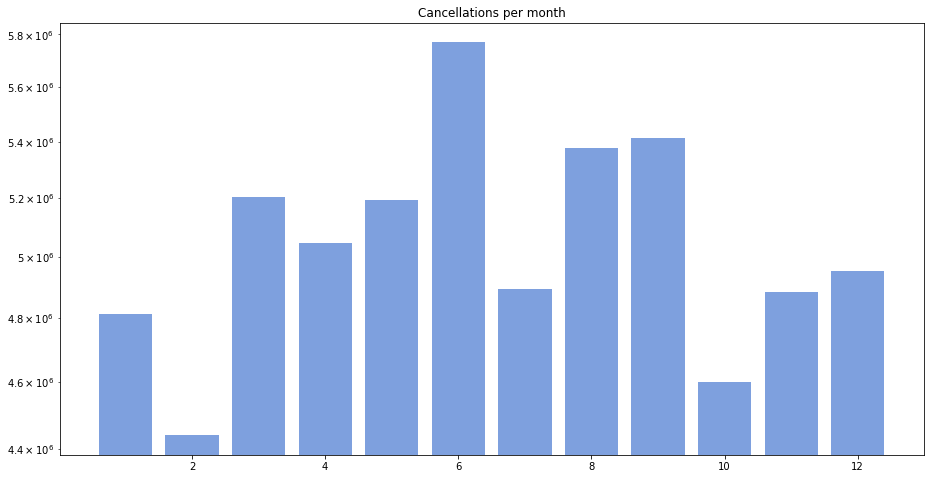

In [ ]:
fig = plt.figure()
ax = fig.add_axes([1,0,2,1.5])
classes = [x[0] for x in no_cancelled_flights_per_month]
values = [x[1] for x in no_cancelled_flights_per_month]
ax.bar(classes, values, alpha=0.7, log=True)
ax.set_title(f"Cancellations per month")
plt.show()

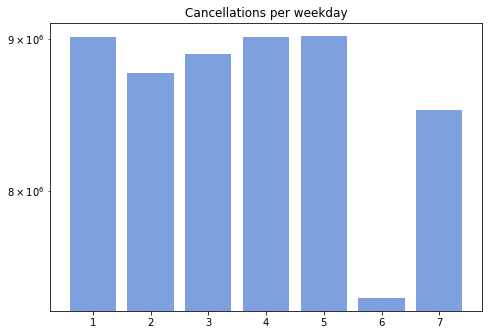

In [ ]:
fig = plt.figure()
ax = fig.add_axes([1,0,1,1])
classes = [x[0] for x in no_cancelled_flights_per_weekday]
values = [x[1] for x in no_cancelled_flights_per_weekday]
ax.bar(classes, values, alpha=0.7, log=True)
ax.set_title(f"Cancellations per weekday")
plt.show()

### Dataset balancing through Undersampling
Since 1) the training dataset is really unbalanced (as the barplot shows), and 2) the class of Regular Flights contains (as expected) a lot of data, we proceed with an undersampling approach.

In [ ]:
no_cancelled_flights = train_rdd.filter(lambda x: x[0] == 1).count()
print("The number of cancelled flight in training set is ", no_cancelled_flights)
no_regular_flights = train_rdd.filter(lambda x: x[0] == -1).count()
print("The number of regular flight in training set is ",no_regular_flights)

The number of cancelled flight in training set is  773905


The number of regular flight in training set is  47894949


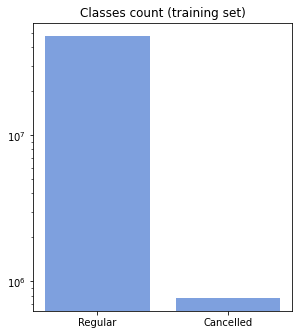

The training set shows an imbalance ratio of 61.88737506541501


In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,0.6,1])
classes = ['Regular', 'Cancelled']
values = [no_regular_flights, no_cancelled_flights]
ax.bar(classes, values, alpha=0.7, log=True)
ax.set_title(f"Classes count (training set)")
plt.show()

print(f'The training set shows an imbalance ratio of {no_regular_flights/no_cancelled_flights}')

In [18]:
# The fractions values were computed according to number of cancelled flight in the 
# considered dataset, aiming at classes balancing

fractions_train = {-1: 0.0162, 1: 1.0}
fractions_val = {-1: 0.0147, 1: 1.0}
sampled_train_rdd = train_rdd.sampleByKey(False, fractions_train)
sampled_val_rdd = val_rdd.sampleByKey(False, fractions_val)

In [19]:
train_rdd = sampled_train_rdd.map(lambda x: (x[1], x[0]))
val_rdd = sampled_val_rdd.map(lambda x: (x[1], x[0]))
test_rdd = test_rdd.map(lambda x: (x[1], x[0]))

### Z-score normalization
This step is essential to make the Logistic Regression model learn properly. A neural network may work with non-normalized data, because the number of parameters is often sufficient to learn the various scales of the data. In this case the number of weights is significantly less and this step is a must.

In [ ]:
# WARNING! Time consuming cell (execute the next one)
temp_rdd = train_rdd.map(lambda x: x[0][:7]) # temp rdd containing the features' values we want to normalize, aiming to compute means and variances
summary = Statistics.colStats(temp_rdd)
means = np.array(summary.mean())  # column-wise mean
stds = np.sqrt(summary.variance())  # column-wise standard deviation

In [20]:
# Execute this cell to avoid waiting for the execution of previous one, these are precomputed values
means = np.array([ 15.72328221, 6.04090796,   2.84695255, 127.17727882, 700.0295384, 57.40500153,  15.97605047])
stds = np.array([  8.93098245,   3.56302623,   1.98154978,  68.01001087, 547.62446162, 5.6612637,    3.86040758])

In [21]:
#Broadcastings vectors of means and standard deviations to all cluster nodes
broadcasted_means = sc.broadcast(means)
broadcasted_stds = sc.broadcast(stds)

#Subtracting mean and dividing by standard deviation column wise
train_rdd = train_rdd.map(lambda x: ( np.concatenate( ((x[0][:7] - broadcasted_means.value)/broadcasted_stds.value, 
                                                       x[0][7:]), axis =None) , x[1] ))

#Using the means and standard deviations of training set for normalizing the test set
val_rdd = val_rdd.map(lambda x: ( np.concatenate( ((x[0][:7] - broadcasted_means.value)/broadcasted_stds.value, 
                                                   x[0][7:]), axis =None) , x[1] ))
test_rdd = test_rdd.map(lambda x: ( np.concatenate( ((x[0][:7] - broadcasted_means.value)/broadcasted_stds.value, 
                                                     x[0][7:]), axis =None) , x[1] ))

# Model learning
In this part of the code you will find a from scratch implementation of the learning algorithm.
The choice of not wrapping inside the Classifier Class functions, such as train(), evaluate(), etc., was somehow forced by the fact that we can't use broadcast variables' values inside a class method (due to PySpark restrictions). Since the process of weights broadcasting is a key ingredient for an actual Distribution of Computation, we resorted to a DataClass that represents the classifier and implemented functions working on the struct.

In [ ]:
@dataclass
class DistributedLogisticRegressionClassifier:
    """
    A data class to represent a Distributed (rdd-based) Logistic Regression Classifier

    Attributes
    ----------
    n_iters :: int
        The number of iterations to do during the Gradient Descent Procedure
    initial_lr : float
        The starting learning rate to consider in the optimization.
    alpha : float
        Regularization parameter
    weights: pyspark.broadcast.Broadcast
        Broadcast variable reference containing the last weights' values
    """
    n_iters : int
    initial_lr : float
    alpha : float
    weights : pyspark.broadcast.Broadcast = None


def log_loss(z):
    """
    Computes the logistic loss for the provided argument in a stable way.

    Attributes
    ----------
    z : float
        The dot product between the datapoint x and the vector of weights, multiplied by the label y (1, -1)

    """
    #return log(1+ exp(-z)) (Non stable)
    return np.logaddexp(0, -z) # Stable

def sigmoid(u):
    """
    Computes the sigmoid function for the provided argument in a stable way.

    Attributes
    ----------
    u : float
        The argument of the function
    """
    #return 1/(1 + exp(-u)) (Non stable)
    return np.exp(-np.logaddexp(0, -u)) # Stable

def compute_gradient_summand(row, w, alpha):
    x = row[0]
    y = row[1]
    return np.add( (1 - sigmoid( (y* dot(w, x)) ))*(-1)*y * x , alpha * w)

def squared_l2_norm(x):
    return np.sum(np.power((x),2))

def cost( clf: DistributedLogisticRegressionClassifier, rdd: pyspark.rdd.PipelinedRDD):
    """
    Computes the average error that the provided DistributedLogisticRegressionClassifier is committing 
    on the provided rdd, with respect to the logarithmic loss.

    Parameters
    ----------
        clf :: DistributedLogisticRegressionClassifier
            A DistributedLogisticRegressionClassifier object whose hyperparameters are correctly initialized.

        train_rdd :: pyspark.rdd.PipelinedRDD
            A paired rdd, whose tuplets are expected to be labeled datapoints with the form: (values: np.array, label: int ), to compute the cost of the classifier on.

    Returns
    ------
        cost :: float
            Average error of the classifier on the provided rdd.
    """
    rdd = rdd.map(lambda x: (np.insert(x[0], 0, 1), x[1])) # Affine transformation: : concatenating a column of 1 to data matrix
    n = rdd.count()
    losses = rdd.map(lambda x: log_loss( x[1]* dot(x[0], clf.weights.value)) + clf.alpha * squared_l2_norm(clf.weights.value) ) #Log loss + Regularization with squared l2 norm
    return losses.reduce(lambda x, y: x + y)/n

def train( clf: DistributedLogisticRegressionClassifier, train_rdd: pyspark.rdd.PipelinedRDD, mini_batch: bool):
    """
    Trains the provided DistributedLogisticRegressionClassifier in a distributed fashion
    using data from a paired rdd (train_rdd) containing labeled datapoints.

    Parameters
    ----------
        clf :: DistributedLogisticRegressionClassifier
            A DistributedLogisticRegressionClassifier object whose hyperparameters are correctly initialized.

        train_rdd :: pyspark.rdd.PipelinedRDD
            A paired rdd, whose tuplets are expected to be labeled datapoints with the form: (values: np.array, label: int ), to train the classifier on.
        
        mini_batch :: bool
            Using or not using mini batches during training, if False we use classical determinist gradient descent
    Returns
    ------
        weights :: np.array
            The last found weights' values
        loss_history :: list
            A list containg the loss evolution during training
    """
    train_rdd = train_rdd.map(lambda x: (np.insert(x[0], 0, 1), x[1])) # Affine transformation: : concatenating a column of 1 to data matrix
    w = np.zeros( train_rdd.first()[0].shape[0] )
    clf.weights = sc.broadcast(w)       # broadcasting weights
    cost_history = []
    n = train_rdd.count()

    progressbar = tqdm(range( clf.n_iters ))
    for i in progressbar:

        if mini_batch:
            temp_rdd = train_rdd.sample(withReplacement = False, fraction = 0.01)
            gradient_terms = temp_rdd.map(lambda row: compute_gradient_summand( row, clf.weights.value, clf.alpha))\
                              .reduce(lambda row1, row2: np.add(row1, row2)) / (n*0.01)
        else:
            gradient_terms = train_rdd.map(lambda row: compute_gradient_summand( row, clf.weights.value, clf.alpha))\
                                .reduce(lambda row1, row2: np.add(row1, row2)) / n
        
        learning_rate = clf.initial_lr / np.sqrt( 1 + i ) #decaying the learning rate 
        step = learning_rate * gradient_terms
        w = clf.weights.value - step
        clf.weights = sc.broadcast(w)    # re-broadcasting weights at each iteration

        losses = train_rdd.map(lambda x: log_loss( x[1]* dot(x[0], clf.weights.value))  + clf.alpha * squared_l2_norm(clf.weights.value) )
        cost = losses.reduce(lambda x, y: x + y)/n
        progressbar.set_description(f"cost: {cost}", refresh=True)
        cost_history.append( cost )

    return clf.weights.value, cost_history
  
def evaluate( clf: DistributedLogisticRegressionClassifier, test_rdd: pyspark.rdd.PipelinedRDD, run_type: str ):
    """
    Evaluates the provided DistributedLogisticRegressionClassifier in a distributed fashion
    using data from a paired rdd (test_rdd) containing labeled datapoints

    Parameters
    ----------
        clf :: DistributedLogisticRegressionClassifier
            A DistributedLogisticRegressionClassifier object whose hyperparameters are correctly initialized.

        test_rdd :: pyspark.rdd.PipelinedRDD
            A paired rdd, whose tuplets are expected to be labeled datapoints with the form: (values: np.array, label: int ), to evaluate the classifier on.

        run_type :: str
            A string describing the type of evaluation, Eg: train, test, val.

    Returns
    ------
        evaluation :: pd.DataFrame
            DataFrame containing the evaluation of the Model on commonly used metrics in the binary classification setting.
    """
    cost_logloss = cost(clf, test_rdd)
    test_rdd = test_rdd.map(lambda x: ( np.insert(x[0], 0, 1), x[1]))
    predictions_rdd = test_rdd.map(lambda x: ( x[1], sigmoid( dot(x[0], clf.weights.value )), 1 if sigmoid( dot(x[0], clf.weights.value ) )>0.5 else -1 ) )

    TN = predictions_rdd.filter(lambda x: x[0] == -1 and x[2] ==-1).count()
    TP = predictions_rdd.filter(lambda x: x[0] == 1 and x[2] ==1).count()
    FN = predictions_rdd.filter(lambda x: x[0] == 1 and x[2] ==-1).count()
    FP = predictions_rdd.filter(lambda x: x[0] == -1 and x[2] ==1).count()
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 =  2 * (precision*recall) / (precision + recall)
    acc = (TP+TN)/(TP+TN+FN+FP)
    recall = TP/(TP+FN)
    specificity = TN/(TN+FP)
    
    # Adapt predictions to MLlib required formate (score: float, label: {0,1})
    predictionAndLabels = predictions_rdd.map(lambda x: ( float(x[1]), 0.0 if x[0]==-1 else 1.0 ))
    metrics = BinaryClassificationMetrics(predictionAndLabels)    
    print(f'TN {TN}, TP {TP}, FN {FN}, FP {FP}')
    return pd.DataFrame([[cost_logloss, f1, acc, recall, specificity, precision, metrics.areaUnderPR,  metrics.areaUnderROC, TP , TN, FP, FN, run_type]], columns = ['Cost', 'F1 score', 'Accuracy', 'Recall', 'Specificity', 'Precision', 'AUPRC', 'AUROC', 'TP', 'TN', 'FP', 'FN', 'run_type'])

In [ ]:
#Warning! Time consuming cell, we cache the rdds so that the training phase will be faster
train_rdd.cache().count()
test_rdd.cache().count()

7213436

In [ ]:
dlr = DistributedLogisticRegressionClassifier( n_iters=100, initial_lr=1, alpha=0.01)
%time w, cost_history = train( dlr, train_rdd , mini_batch = False)

  0%|          | 0/100 [00:00<?, ?it/s]

CPU times: user 27.8 s, sys: 7.19 s, total: 34.9 s
Wall time: 1h 11min 28s


In [ ]:
train_evaluation = evaluate(dlr, train_rdd, 'Train')
test_evaluation = evaluate(dlr, test_rdd, 'Test')

/usr/local/spark/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


TN 480029, TP 485881, FN 288024, FP 296685


TN 4368537, TP 73228, FN 43353, FP 2728318


In [ ]:
evaluations = pd.concat([train_evaluation, test_evaluation])

In [ ]:
evaluations

,Cost,F1 score,Accuracy,Recall,Specificity,Precision,AUPRC,AUROC,TP,TN,FP,FN,run_type
0,0.654575,0.624337,0.622919,0.62783,0.618025,0.620882,0.656440,0.666855,485881,480029,296685,288024,Train
0,0.650197,0.050188,0.615763,0.62813,0.615560,0.026138,0.031957,0.666136,73228,4368537,2728318,43353,Test


### Comparison with PySpark MLlib LogisticRegressionWithSGD model

#### Comparing performances
In order to compare performances we need to transform -1 labels to 0 labels and create an RDD that contains LabeledPoint instances (this is required by MLLib implementation)

In [22]:
train_01labels = train_rdd.map(lambda x: LabeledPoint(label = 1 if x[1]==1 else 0, features = x[0]))
test_01labels = test_rdd.map(lambda x: LabeledPoint(label = 1 if x[1]==1 else 0, features = x[0]))

In [ ]:
#Warning! Time consuming cell, caching the two rdds
train_01labels.cache().count()
test_01labels.cache().count()

7213436

In [ ]:
%time lrm = LogisticRegressionWithSGD.train( train_01labels, iterations=100, regParam = 0.01, validateData=False, intercept=True, convergenceTol = 0)

/usr/local/spark/python/pyspark/mllib/classification.py:325: FutureWarning: Deprecated in 2.0.0. Use ml.classification.LogisticRegression or LogisticRegressionWithLBFGS.
  warnings.warn(


CPU times: user 6.29 s, sys: 1.86 s, total: 8.15 s
Wall time: 57min 48s


In [ ]:
def log_loss2(y, y_hat):
  """
  Computes the logistic loss for the provided argument in a stable way, considering that labels are (0, 1).

  """
  return y * np.logaddexp(0, -y_hat) + (1-y) * np.logaddexp(0, y_hat)

lrm.clearThreshold()
# Computing the cost on training data
cost_lrm = train_01labels.map(lambda p: log_loss2( p.label, lrm.predict(p.features) ) ).\
                                        reduce(lambda x, y: x+y) / train_01labels.count()
print('The cost of the PySpark MLlib implementation is ', cost_lrm)

The cost of the PySpark MLlib implementation is  0.7084285913507112


In [ ]:
# Evaluating the model on test data
predictionAndLabels = test_01labels.map(lambda lp: (float(lrm.predict(lp.features)), lp.label))
metrics = BinaryClassificationMetrics(predictionAndLabels)

# Area under precision-recall curve
print("Area under PR = %s" % metrics.areaUnderPR)

# Area under ROC curve
print("Area under ROC = %s" % metrics.areaUnderROC)

/usr/local/spark/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Area under PR = 0.03223126768987526
Area under ROC = 0.6673918923736566


#### Comparing weights' vectors

In [ ]:
dlr_weights = np.array(w[1:])
lrm_weights = np.array(lrm.weights)
np.set_printoptions(suppress=True)

In [ ]:
print("The DistributedLogisticRegression weights are \n", dlr_weights)

The DistributedLogisticRegression weights are 
 [ 0.01371916 -0.25346907 -0.06927461 -0.08836145 -0.166952    0.27612419
  0.12842483 -0.03877994  0.0663145  -0.00029506  0.07250191 -0.02085119
  0.0119814  -0.1885774  -0.0094984  -0.01437772 -0.03475279 -0.03792034
  0.13786286 -0.00787203  0.03039421 -0.04225999 -0.10707362  0.0026105
 -0.01903167  0.02158695  0.00556203  0.04021875  0.0145203  -0.02943596
  0.18663267  0.07525165  0.        ]


In [ ]:
print("The LogisticRegressionWithSGD weights are \n", lrm_weights)

The LogisticRegressionWithSGD weights are 
 [ 0.01317415 -0.25445629 -0.06932562 -0.09006907 -0.17119094  0.27478791
  0.12471993 -0.01071964  0.12618879  0.0427246   0.10962865 -0.03083971
 -0.00472708 -0.25258871 -0.04261749 -0.01796571 -0.05020806 -0.04391882
  0.0619546  -0.01161006  0.00685804 -0.05981104 -0.20052228 -0.04853666
 -0.05849256  0.01319756 -0.00032005 -0.03418982 -0.00293288 -0.03827036
  0.12365723  0.00808996  0.        ]


In [ ]:
np.allclose(dlr_weights, lrm_weights, rtol=0.0, atol=0.1)

True

In [ ]:
print(f"The mean squared error between the two weights vectors is {(np.square(np.array(lrm.weights) - w[1:])).mean(axis=0)}")

The mean squared error between the two weights vectors is 0.0014407515227577166


#### Comparing execution time

The execution time for both our implementation and MLLib one is very large and comparable, this is due to the fact that everything is run locally (we are just simulating parallelism). Clearly the MLLib implementation has a slight advantage because to optimize the cost function we just need to do an API call and then all the code is executed in Scala.

### Is Mini Batch Gradient Descent effective in this setting?
By working on a batch of the rdd at a time, the improvement made in one iteration may be little and thus more iterations are required to converge.
Moreover, at each iteration the main rdd has to be sampled. Since Spark is lazy, some parts of the DAG concerning the operations on the main rdd might be re executed, causing enormous delays in the execution. Indeed there is not a strong difference between execution times.

In [ ]:
#Warning! Time consuming cell, caching the rdd
train_rdd.cache().count()

1550619

In [ ]:
dlr = DistributedLogisticRegressionClassifier( n_iters=100, initial_lr=1.0, alpha=0.01)
%time w1 , minibatch_cost_history = train( dlr, train_rdd , mini_batch = True)
%time w2 , vanilla_cost_history = train( dlr, train_rdd , mini_batch = False)

  0%|          | 0/100 [00:00<?, ?it/s]

CPU times: user 22.7 s, sys: 5.33 s, total: 28.1 s
Wall time: 51min 55s


  0%|          | 0/100 [00:00<?, ?it/s]

CPU times: user 25.2 s, sys: 6.37 s, total: 31.6 s
Wall time: 1h 9min 28s


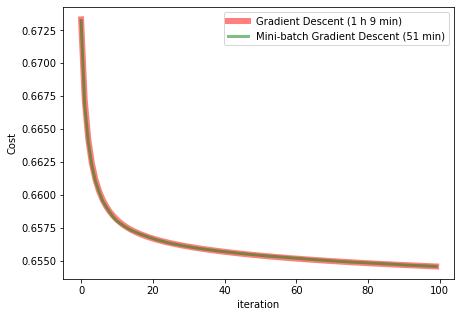

In [ ]:
fig = plt.figure(figsize=(7, 5))
x = [x for x in range(100)]
  
# plot lines
plt.plot(x, vanilla_cost_history, label = "Gradient Descent (1 h 9 min)", alpha=0.5, lw=6, color='red')
plt.plot(x, minibatch_cost_history, label = "Mini-batch Gradient Descent (51 min)", alpha=0.5, lw=3, color='green')
plt.ylabel('Cost')
plt.xlabel('iteration')
plt.legend()
plt.show()

# Hyperparameters tuning

We will settle for a RandomSearch (30 trials) because of the prohibitive execution training time.

In [ ]:
#Warning! Time consuming cell, caching the two rdds
train_rdd.cache().count()
val_rdd.cache().count()

165025

In [ ]:
class RandomSearchTuner:
    def __init__(self, param_grid):
        self.param_grid = param_grid
        self.results = dict()

    def search(self, train_rdd: pyspark.rdd.RDD , validation_rdd: pyspark.rdd.RDD, n_trials: int):
        param_lists = [ [ param_value for param_value in self.param_grid[param]]for param in self.param_grid]
        # We compute all possible combinations for our param_grid using itertools.product
        grid = list(product(*param_lists))
        random.shuffle(grid)
        reduced_grid = grid[:n_trials]
        
        for configuration in reduced_grid:    
            # Now we unpack parameters' values to make them act as multiple arguments for the __init__ function of the ModelClass
            current_dlr = DistributedLogisticRegressionClassifier(*[value for value in configuration])
            train( current_dlr, train_rdd , mini_batch = False)

            key = tuple(value for value in configuration)
            print(f'Configuration: lr={current_dlr.initial_lr}, alpha={current_dlr.alpha}, max_iter={current_dlr.n_iters}')
            evaluation = cost(current_dlr, validation_rdd)
            self.results[key] = evaluation
        return self.results
    
    def evaluate_bestconfig(self, train_rdd: pyspark.rdd.RDD , validation_rdd: pyspark.rdd.RDD, test_rdd: pyspark.rdd.RDD):
        train_rdd = train_rdd.union(validation_rdd)
        best_configuration = min(self.results, key=self.results.get) #argmin of dictionary
        print("The best configuration we are evaluating is ", best_configuration)
        dlr = DistributedLogisticRegressionClassifier(*[value for value in best_configuration])
        train(dlr, train_rdd, mini_batch=False)
        return evaluate(dlr, test_rdd, 'tuning_test')

### Searching best hyperparameters

In [ ]:
param_grid = { 'n_iters': [10, 50, 100],
               'intial_lr': [0.01, 0.1, 1] ,
               'alpha': [0.0001, 0.001, 0.01, 0.1]
             }

tuner = RandomSearchTuner(param_grid)
tuner.search(train_rdd, val_rdd, 30)

  0%|          | 0/100 [00:00<?, ?it/s]

Configuration: lr=0.1, alpha=0.1, max_iter=100


  0%|          | 0/100 [00:00<?, ?it/s]

Configuration: lr=0.01, alpha=0.1, max_iter=100


  0%|          | 0/50 [00:00<?, ?it/s]

Configuration: lr=0.01, alpha=0.001, max_iter=50


  0%|          | 0/10 [00:00<?, ?it/s]

Configuration: lr=0.1, alpha=0.001, max_iter=10


  0%|          | 0/50 [00:00<?, ?it/s]

Configuration: lr=0.1, alpha=0.001, max_iter=50


  0%|          | 0/100 [00:00<?, ?it/s]

Configuration: lr=1, alpha=0.1, max_iter=100


  0%|          | 0/10 [00:00<?, ?it/s]

Configuration: lr=1, alpha=0.001, max_iter=10


  0%|          | 0/10 [00:00<?, ?it/s]

Configuration: lr=1, alpha=0.1, max_iter=10


  0%|          | 0/50 [00:00<?, ?it/s]

Configuration: lr=0.01, alpha=0.1, max_iter=50


  0%|          | 0/10 [00:00<?, ?it/s]

Configuration: lr=1, alpha=0.01, max_iter=10


  0%|          | 0/10 [00:00<?, ?it/s]

Configuration: lr=0.1, alpha=0.01, max_iter=10


  0%|          | 0/100 [00:00<?, ?it/s]

Configuration: lr=0.1, alpha=0.001, max_iter=100


  0%|          | 0/10 [00:00<?, ?it/s]

Configuration: lr=0.01, alpha=0.1, max_iter=10


  0%|          | 0/10 [00:00<?, ?it/s]

Configuration: lr=0.1, alpha=0.0001, max_iter=10


  0%|          | 0/100 [00:00<?, ?it/s]

Configuration: lr=1, alpha=0.001, max_iter=100


  0%|          | 0/10 [00:00<?, ?it/s]

Configuration: lr=1, alpha=0.0001, max_iter=10


  0%|          | 0/10 [00:00<?, ?it/s]

Configuration: lr=0.01, alpha=0.01, max_iter=10


  0%|          | 0/100 [00:00<?, ?it/s]

Configuration: lr=0.01, alpha=0.001, max_iter=100


  0%|          | 0/100 [00:00<?, ?it/s]

Configuration: lr=1, alpha=0.0001, max_iter=100


  0%|          | 0/50 [00:00<?, ?it/s]

Configuration: lr=0.01, alpha=0.0001, max_iter=50


  0%|          | 0/100 [00:00<?, ?it/s]

Configuration: lr=0.1, alpha=0.01, max_iter=100


  0%|          | 0/100 [00:00<?, ?it/s]

Configuration: lr=1, alpha=0.01, max_iter=100


  0%|          | 0/50 [00:00<?, ?it/s]

Configuration: lr=1, alpha=0.1, max_iter=50


  0%|          | 0/50 [00:00<?, ?it/s]

Configuration: lr=1, alpha=0.001, max_iter=50


  0%|          | 0/50 [00:00<?, ?it/s]

Configuration: lr=1, alpha=0.0001, max_iter=50


  0%|          | 0/50 [00:00<?, ?it/s]

Configuration: lr=0.1, alpha=0.1, max_iter=50


  0%|          | 0/50 [00:00<?, ?it/s]

Configuration: lr=0.1, alpha=0.0001, max_iter=50


  0%|          | 0/50 [00:00<?, ?it/s]

Configuration: lr=0.01, alpha=0.01, max_iter=50


  0%|          | 0/10 [00:00<?, ?it/s]

Configuration: lr=0.1, alpha=0.1, max_iter=10


  0%|          | 0/10 [00:00<?, ?it/s]

Configuration: lr=0.01, alpha=0.0001, max_iter=10


{(100, 0.1, 0.1): 0.6843618042723085,
 (100, 0.01, 0.1): 0.6905243767777646,
 (50, 0.01, 0.001): 0.6912241289459173,
 (10, 0.1, 0.001): 0.6867867869122053,
 (50, 0.1, 0.001): 0.6817764721966282,
 (100, 1, 0.1): 0.6945973560774347,
 (10, 1, 0.001): 0.6804142152367573,
 (10, 1, 0.1): 0.6901445959432605,
 (50, 0.01, 0.1): 0.6912727251909132,
 (10, 1, 0.01): 0.6816215203624219,
 (10, 0.1, 0.01): 0.6868444991498428,
 (100, 0.1, 0.001): 0.68007587238274,
 (10, 0.01, 0.1): 0.6923675232185958,
 (10, 0.1, 0.0001): 0.6867809942743575,
 (100, 1, 0.001): 0.6832448060270521,
 (10, 1, 0.0001): 0.6802890398635975,
 (10, 0.01, 0.01): 0.6923605124734471,
 (100, 0.01, 0.001): 0.6904242280500693,
 (100, 1, 0.0001): 0.6830054973053228,
 (50, 0.01, 0.0001): 0.691223682576176,
 (100, 0.1, 0.01): 0.6805188167517382,
 (100, 1, 0.01): 0.6853935890127375,
 (50, 1, 0.1): 0.6939651899278982,
 (50, 1, 0.001): 0.68301526545674,
 (50, 1, 0.0001): 0.6828230488556717,
 (50, 0.1, 0.1): 0.684443233873553,
 (50, 0.1, 0.0

In [ ]:
tuner.results

{(100, 0.1, 0.1): 0.6843618042723085,
 (100, 0.01, 0.1): 0.6905243767777646,
 (50, 0.01, 0.001): 0.6912241289459173,
 (10, 0.1, 0.001): 0.6867867869122053,
 (50, 0.1, 0.001): 0.6817764721966282,
 (100, 1, 0.1): 0.6945973560774347,
 (10, 1, 0.001): 0.6804142152367573,
 (10, 1, 0.1): 0.6901445959432605,
 (50, 0.01, 0.1): 0.6912727251909132,
 (10, 1, 0.01): 0.6816215203624219,
 (10, 0.1, 0.01): 0.6868444991498428,
 (100, 0.1, 0.001): 0.68007587238274,
 (10, 0.01, 0.1): 0.6923675232185958,
 (10, 0.1, 0.0001): 0.6867809942743575,
 (100, 1, 0.001): 0.6832448060270521,
 (10, 1, 0.0001): 0.6802890398635975,
 (10, 0.01, 0.01): 0.6923605124734471,
 (100, 0.01, 0.001): 0.6904242280500693,
 (100, 1, 0.0001): 0.6830054973053228,
 (50, 0.01, 0.0001): 0.691223682576176,
 (100, 0.1, 0.01): 0.6805188167517382,
 (100, 1, 0.01): 0.6853935890127375,
 (50, 1, 0.1): 0.6939651899278982,
 (50, 1, 0.001): 0.68301526545674,
 (50, 1, 0.0001): 0.6828230488556717,
 (50, 0.1, 0.1): 0.684443233873553,
 (50, 0.1, 0.0

### Tuning performances

In [ ]:
tuner.evaluate_bestconfig(train_rdd, val_rdd, test_rdd)

The best configuration we are evaluating is  (100, 0.1, 0.001)


  0%|          | 0/100 [00:00<?, ?it/s]

TN 4219691, TP 73887, FN 42694, FP 2877164


,Cost,F1 score,Accuracy,Recall,Specificity,Precision,AUPRC,AUROC,TP,TN,FP,FN,run_type
0,0.664842,0.048172,0.59522,0.633783,0.594586,0.025038,0.03101,0.657497,73887,4219691,2877164,42694,tuning_test


In [30]:
data = [np.array([x[0], x[1], x[2], tuner.results[x]]) for x in tuner.results]
data = pd.DataFrame(data, columns= ['n_iters', 'lr', 'alpha', 'cost'])

import plotly.graph_objects as go

fig = go.Figure(data=[go.Scatter3d(
    x=data['lr'],
    y=data['alpha'],
    z=data['n_iters'],
    mode='markers',
    text=('lr', 'alpha', 'n_iters'),
    marker=dict(
        color=data['cost'],                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8,
        size=14, colorbar=dict(thickness=20)
    )
)])


# tight layout
fig.update_layout(
    autosize=False,
    width=600, 
    height=600,
    title='Hyperparameters space', 
    margin=dict(l=0, r=0, b=0, t=0),
    scene=dict(
        xaxis_title='learning rate',
        yaxis_title='alpha',
        zaxis_title='no. iters',
    ),
)

fig.show()

# Bonus: Decision Tree

In [23]:
#Warning! Time consuming cell, caching the two rdds
train_01labels.cache().count()
test_01labels.cache().count()

7213436

In [24]:
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
from pyspark.mllib.util import MLUtils

In [25]:
model = DecisionTree.trainClassifier(train_01labels, numClasses=2, categoricalFeaturesInfo={}, 
                                     impurity='gini', maxDepth=10, maxBins=32)

# Compute training error (based on 0/1 loss)
predictions = model.predict(train_01labels.map(lambda x: x.features))
labelsAndPredictions = train_01labels.map(lambda lp: lp.label).zip(predictions)
trainErr = labelsAndPredictions.filter( lambda lp: lp[0] != lp[1]).count() / float(train_01labels.count())
print('Train Error = ' + str(trainErr))

Train Error = 0.3273334494975896


In [26]:
predictions = model.predict(test_01labels.map(lambda x: x.features))
labelsAndPredictions = test_01labels.map(lambda lp: lp.label).zip(predictions)
TN = labelsAndPredictions.filter(lambda x: x[0] == 0 and x[1] ==0).count()
TP = labelsAndPredictions.filter(lambda x: x[0] == 1 and x[1] ==1).count()
FN = labelsAndPredictions.filter(lambda x: x[0] == 1 and x[1] ==0).count()
FP = labelsAndPredictions.filter(lambda x: x[0] == 0 and x[1] ==1).count()
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 =  2 * (precision*recall) / (precision + recall)
acc = (TP+TN)/(TP+TN+FN+FP)
recall = TP/(TP+FN)
specificity = TN/(TN+FP)

In [27]:
pd.DataFrame([[f1, acc, recall, precision, specificity, TP , TN, FP, FN]], columns = ['F1 score', 'Accuracy', 'Recall', 'Precision',  'specificity','TP', 'TN', 'FP', 'FN'])

,F1 score,Accuracy,Recall,Precision,specificity,TP,TN,FP,FN
0,0.053688,0.711215,0.506875,0.028345,0.714572,59092,5071214,2025641,57489
